<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/The%20Market's%20Not%20Normal/The_Autocorrelation_of_Variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Autocorrelation of Variance
## Introduction


## Import the Standard Libary
I put everything I use "most of the time" into a python file called `my_library.py` which you must import into the workspace of this notebook to make the analysis execute. The file is available here: [`my_library.py`](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/The%20Market's%20Not%20Normal/my_library.py).

In [1]:
from my_library import *

13:58:35 Starting...
13:58:35 Installing yfinance into Google notebook...
13:58:48 Installing arch into Google notebook...
13:59:00 Initialized.


## Read the Data from _Yahoo! Finance_
I'm going to use _Yahoo! Finance_ as a data source as it is publicly available and easy to access via the `yfinance` package. You could substitute other vendors, if you have access to them.

In [2]:
df,name=download(ticker:='^GSPC',begin:='1928-01-27',end:=today('%Y-%m-%d')).dropna(),'S&P 500 Index'
df['Daily Return']=df['Adj Close'].pct_change()*hundred
df['Intraday Return']=df['Close']/df['Open']*hundred-hundred
df['Overnight Return']=(hundred+df["Daily Return"])/(hundred+df["Intraday Return"])*hundred-hundred
df.index=pd.DatetimeIndex(df.index).to_period('B')
df.dropna(inplace=True)
df.loc[df["Volume"]==0,"Volume"]=np.nan # fix early zero volumes
df.loc[:df.index[pd.Series(np.where(df['Open']==df['Close'],np.nan,one)).first_valid_index()-1],"Intraday Return"]=np.nan # fix early data without intraday pricing
nprint("\nDownloaded data for %s." % name)
display(df)

[*********************100%%**********************]  1 of 1 completed

13:59:02 
Downloaded data for S&P 500 Index.


,Open,High,Low,Close,Adj Close,Volume,Daily Return,Intraday Return,Overnight Return
Date,,,,,,,,,
1928-01-30,17.490000,17.490000,17.490000,17.490000,17.490000,NaN,-1.130587,NaN,-1.130587
1928-01-31,17.570000,17.570000,17.570000,17.570000,17.570000,NaN,0.457404,NaN,0.457404
1928-02-01,17.530001,17.530001,17.530001,17.530001,17.530001,NaN,-0.227655,NaN,-0.227655
1928-02-02,17.629999,17.629999,17.629999,17.629999,17.629999,NaN,0.570442,NaN,0.570442
1928-02-03,17.400000,17.400000,17.400000,17.400000,17.400000,NaN,-1.304592,NaN,-1.304592
...,...,...,...,...,...,...,...,...,...
2024-06-21,5466.770020,5478.310059,5452.029785,5464.620117,5464.620117,6.773800e+09,-0.156213,-0.039327,-0.116932
2024-06-24,5459.580078,5490.660156,5447.589844,5447.870117,5447.870117,3.696750e+09,-0.306517,-0.214485,-0.092230
2024-06-25,5460.729980,5472.879883,5446.560059,5469.299805,5469.299805,3.591960e+09,0.393359,0.156936,0.236053


## Computing the Autocorrelation Function of Squared Returns





14:29:40 Computing ACF of squared returns...
14:29:40                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1404.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):          1.50e-147
Time:                        14:29:40   Log-Likelihood:                 115.75
No. Observations:                 504   AIC:                            -227.5
Df Residuals:                     502   BIC:                            -219.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

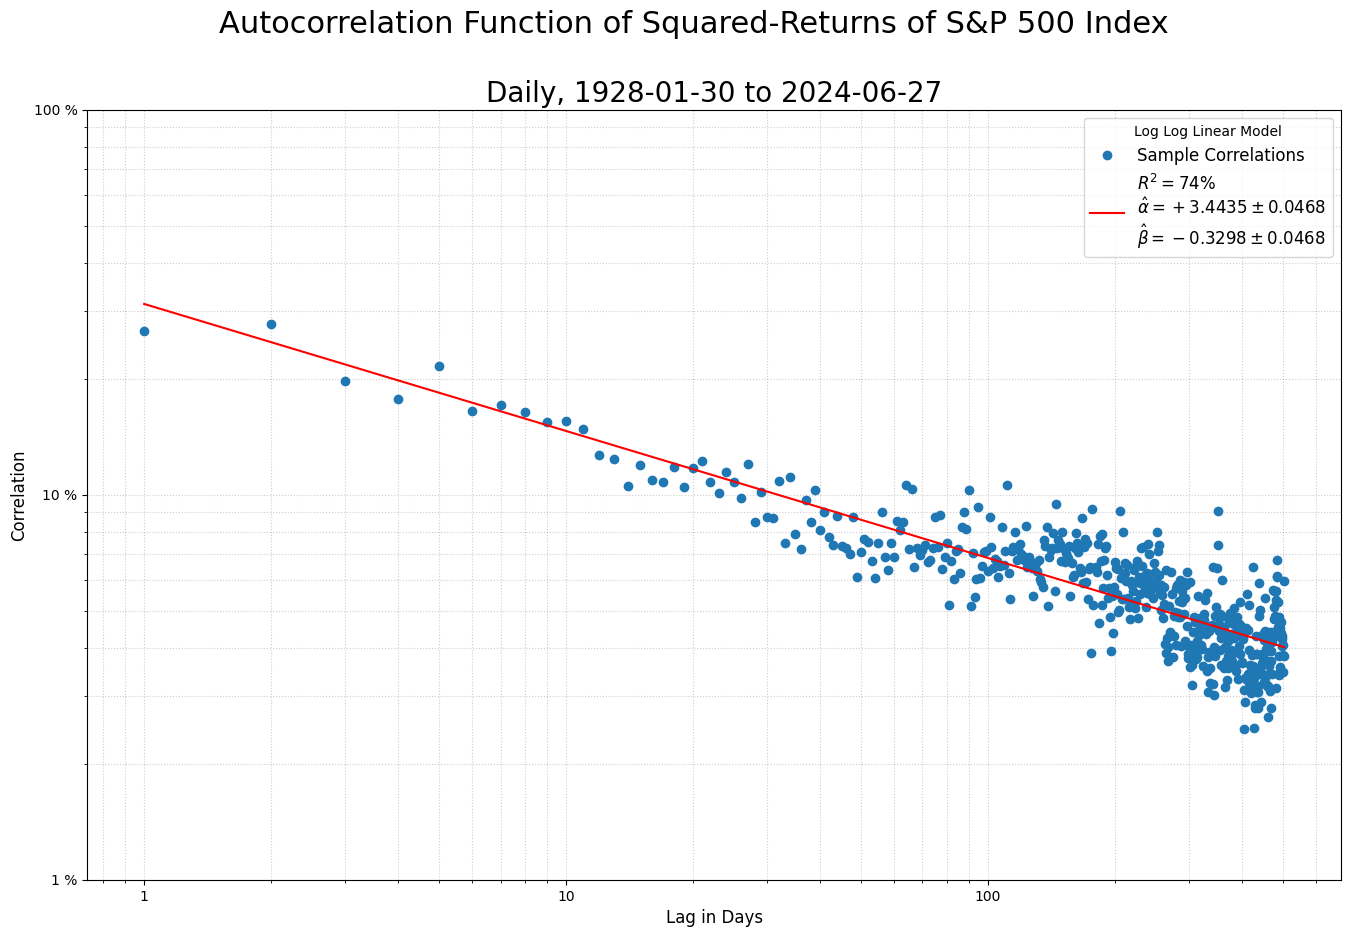

In [10]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS

nprint("Computing ACF of squared returns...")
df['r2']=df['Daily Return']**2
df['ar']=df['Daily Return'].abs()
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=np.linspace(1,nlag:=int(annualize*two),nlag),y:=acf(df['r2'],nlags=nlag)[1:]*hundred,'o',label='Sample Correlations')
model=OLS(np.log(y),add_constant(np.log(x))).fit()
nprint(model.summary())
plot.plot(x,np.exp(model.predict()),'-r',label='$R^2 = %.0f \\%%$\n$\\hat{\\alpha} = %+6.4f \\pm %.4f$\n$\\hat{\\beta}= %+6.4f \\pm %.4f$' % \
  (model.rsquared*hundred,model.params[0],model.bse[0],model.params[1],model.bse[0]))
plot.set_xscale('log')
plot.set_yscale('log')
plot.grid('both','both',alpha=0.2,linestyle=':',color='black')
plot.xaxis.set_major_formatter(CountLabels(0))
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.set_ylim(one,hundred)
plot.set_xlabel("Lag in Days",fontsize=12)
plot.set_ylabel("Correlation",fontsize=12)
figure.suptitle(title:="Autocorrelation Function of Squared-Returns of S&P 500 Index",fontsize=22)
plot.set_title(subtitle:="Daily, %s to %s" % (df.index[0],df.index[-1]),fontsize=20)
plot.legend(fontsize=12,title='Log Log Linear Model')
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

13:59:13 Computing Directional Autocorrelation Function


Lagged                      Negatives                      Positives  \
    Correlation     Error   Sample Correlation     Error   Sample Correlation   
Lag                                                                             
1     26.570372  0.642630  24217.0   32.987620  0.943999  11224.0   18.200062   
2     27.814160  0.642643  24216.0   30.055567  0.943999  11224.0   25.666485   
3     19.723611  0.642656  24215.0   19.817906  0.943999  11224.0   20.013987   
4     17.770389  0.642669  24214.0   23.733354  0.944041  11223.0   12.599078   
5     21.632509  0.642683  24213.0   23.560855  0.944083  11222.0   19.554644   
..          ...       ...      ...         ...       ...      ...         ...   
500    4.035734  0.649355  23718.0    4.125834  0.954258  10984.0    3.896951   
501    4.284941  0.649369  23717.0    2.627885  0.954302  10983.0    6.578341   
502    3.652379  0.649383  23716.0    3.983708  0.954345  10982.0    3.397028   
503    6.266359  0.649396  23715.0    7.713615  0.954389  10981.0    4.823125   
504    4.011545  0.649410  23714.0    3.403981  0.954432  10980.0    4.931202   

                        
        Error   Sample  
Lag                     
1    0.888138  12680.0  
2    0.888173  12679.0  
3    0.888208  12678.0  
4    0.888208  12678.0  
5    0.888208  12678.0  
..        ...      ...  
500  0.897351  12421.0  
501  0.897351  12421.0  
502  0.897351  12421.0  
503  0.897351  12421.0  
504  0.897351  12421.0  

[504 rows x 9 columns]

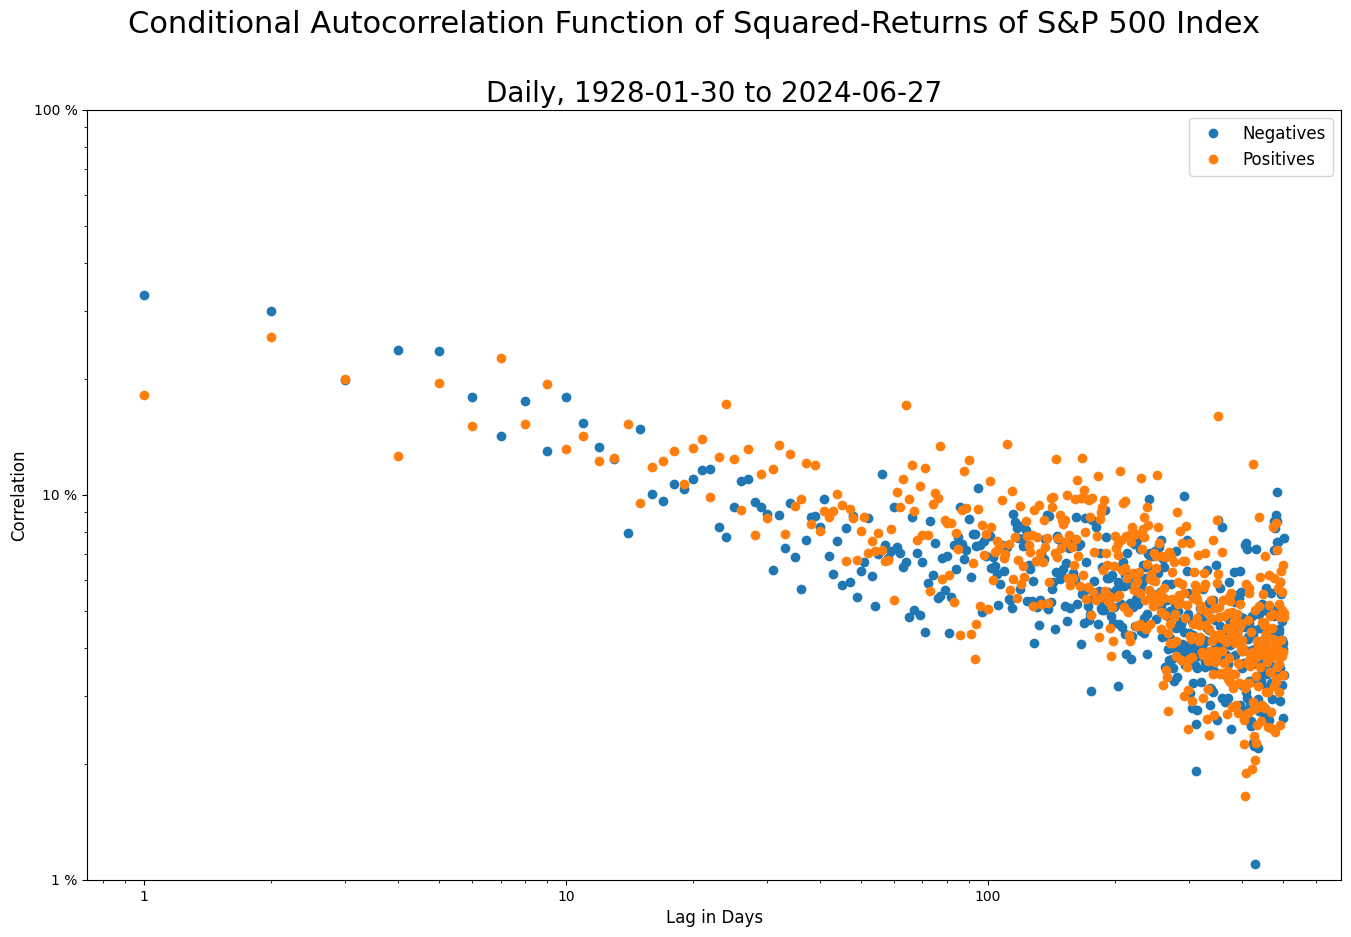

In [4]:
nprint("Computing Directional Autocorrelation Function")
df["nr2"]=df["Daily Return"].apply(lambda x:x**2 if x<zero else np.nan)
df["pr2"]=df["Daily Return"].apply(lambda x:x**2 if x>zero else np.nan)
results=pd.DataFrame({"Lag":list(map(int,x))}).set_index("Lag")

for lag in results.index:
    sample=df[["Daily Return","r2","nr2","pr2"]].copy()
    sample["Lagged"]=sample["r2"].shift(lag)
    sample["Negatives"]=sample["nr2"].shift(lag)
    sample["Positives"]=sample["pr2"].shift(lag)

    for prior in "Lagged","Negatives","Positives":
        results.loc[lag,prior+" Correlation"]=sample[["r2",prior]].corr().iloc[0,1]*hundred
        results.loc[lag,prior+" Sample"]=sample[["r2",prior]].dropna().shape[0]

results.columns=pd.MultiIndex.from_tuples(list(map(lambda x:x.split(" "),results.columns)))

for column in set(results.columns.get_level_values(0)):
    results[(column,"Error")]=np.tanh(one/np.sqrt(results[(column,"Sample")]-three))*hundred

results=results[sorted(results)]
display(results)
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))

for column in "Negatives","Positives":
    plot.plot(results.index,results[(column,"Correlation")],'o',label=column)

plot.set_xscale('log')
plot.set_yscale('log')
plot.xaxis.set_major_formatter(CountLabels(0))
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.set_ylim(one,hundred)
plot.set_xlabel("Lag in Days",fontsize=12)
plot.set_ylabel("Correlation",fontsize=12)
figure.suptitle(title:="Conditional Autocorrelation Function of Squared-Returns of S&P 500 Index",fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.legend(fontsize=12)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')


13:59:34 Computing PACF of squared returns...


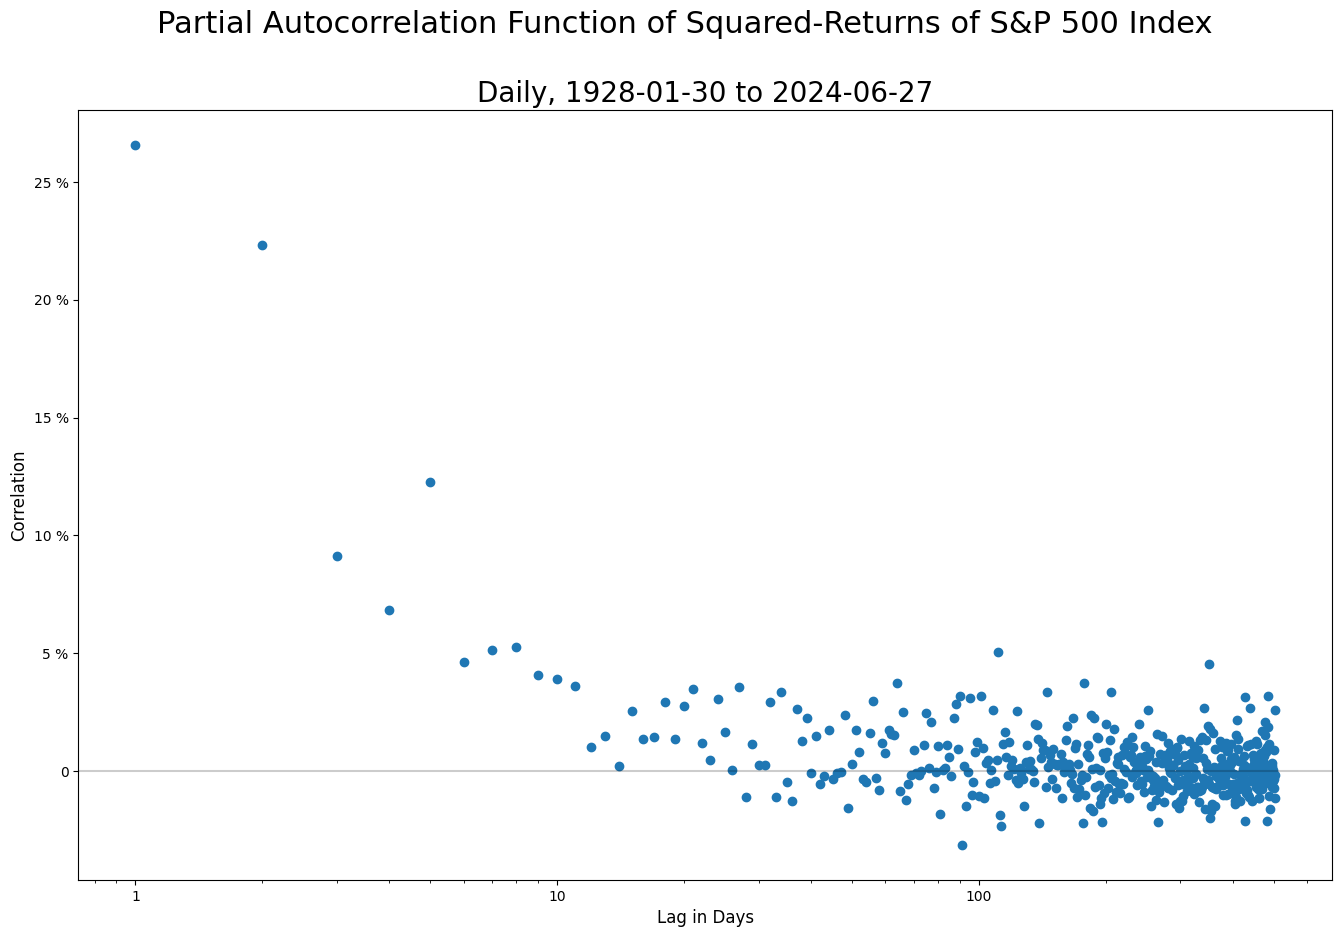

In [5]:
nprint("Computing PACF of squared returns...")
df['r2']=df['Daily Return']**2
df['ar']=df['Daily Return'].abs()
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=np.linspace(1,nlag:=int(annualize*two),nlag),y:=pacf(df['r2'],nlags=nlag)[1:]*hundred,'o')
#plot.set_xlim(,nlag+1)
plot.set_xscale('log')
plot.xaxis.set_major_formatter(CountLabels(0))
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.set_xlabel("Lag in Days",fontsize=12)
plot.set_ylabel("Correlation",fontsize=12)
plot.axhline(color='black',alpha=0.2)
figure.suptitle(title:="Partial Autocorrelation Function of Squared-Returns of S&P 500 Index",fontsize=22)
plot.set_title(subtitle:="Daily, %s to %s" % (df.index[0],df.index[-1]),fontsize=20)
#plot.legend(fontsize=12,title='Log Linear Model')
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [6]:

results

Lagged                      Negatives                      Positives  \
    Correlation     Error   Sample Correlation     Error   Sample Correlation   
Lag                                                                             
1     26.570372  0.642630  24217.0   32.987620  0.943999  11224.0   18.200062   
2     27.814160  0.642643  24216.0   30.055567  0.943999  11224.0   25.666485   
3     19.723611  0.642656  24215.0   19.817906  0.943999  11224.0   20.013987   
4     17.770389  0.642669  24214.0   23.733354  0.944041  11223.0   12.599078   
5     21.632509  0.642683  24213.0   23.560855  0.944083  11222.0   19.554644   
..          ...       ...      ...         ...       ...      ...         ...   
500    4.035734  0.649355  23718.0    4.125834  0.954258  10984.0    3.896951   
501    4.284941  0.649369  23717.0    2.627885  0.954302  10983.0    6.578341   
502    3.652379  0.649383  23716.0    3.983708  0.954345  10982.0    3.397028   
503    6.266359  0.649396  23715.0    7.713615  0.954389  10981.0    4.823125   
504    4.011545  0.649410  23714.0    3.403981  0.954432  10980.0    4.931202   

                        
        Error   Sample  
Lag                     
1    0.888138  12680.0  
2    0.888173  12679.0  
3    0.888208  12678.0  
4    0.888208  12678.0  
5    0.888208  12678.0  
..        ...      ...  
500  0.897351  12421.0  
501  0.897351  12421.0  
502  0.897351  12421.0  
503  0.897351  12421.0  
504  0.897351  12421.0  

[504 rows x 9 columns]